In [3]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [4]:
import warnings
warnings.filterwarnings(
    "ignore",
    message=".*'penalty' was deprecated.*",
    category=FutureWarning
)

In [5]:
rndm_seed = 45

Iniziamo implementando una funzione che crea il network con i relativi pesi, questa servira' per generare i dati e per verificare la bonta' del modello

In [8]:
G = nx.florentine_families_graph()
nx.convert_node_labels_to_integers(G, ordering="sorted")
print(G.number_of_nodes(), G.number_of_edges())

15 20


In [11]:
def build_network_karate(mean=None, std=None, seed=0, network="Karate"):
    """
    Crea una matrice W 'vera' da usare per l'inferenza della rete dopo. Lo faccio usando la topologia del modello scelto:
    -> network == "Karate": N=24, E=78
    -> network == "Miserable": N=77, E=254
    -> network == "Family": N=15, E=20
    input param:
    -> mean: media dei pesi assegnati 
    -> std: dev. standard dei pesi assegnati
    -> seed: seed per la randomicita'
    
    I pesi vengono presi da una normale N(mean, std)
    output:
    -> W: matrice dei pesi del network scelto con i pesi gia' assegnati
    """
    rng = np.random.default_rng(seed)
    
    # prendo il grafo nel network scelto
    if network == "Karate":
        G = nx.karate_club_graph()
    elif network == "Miserable":
        G = nx.les_miserables_graph()
    elif network == "Family":
        G = nx.florentine_families_graph()
    elif network == "Football"
        G = nx.read_gml("data/football.gml")
    else:
        raise ValueError("network non riconosciuto")
    
    G = nx.convert_node_labels_to_integers(G, ordering="sorted")
    
    N = G.number_of_nodes()
    E = G.number_of_edges()
    
    # se non ho la media da cui campionare i pesi la creo basandomi sui valori del grafo
    if mean is None:
        mean = N / (2 * E)
    if std is None:
        std = 0.01
        
    # inizializzo la matrice dei pesi a zero
    W = np.zeros((N, N), dtype=float)

    # riempio la matrice dei pesi e metto valori presi da N(mean, std) solo quando esiste l'arco
    # NB! G.edges() è una lista di tuple (i, j) che mi dice quali archi esistono
    for i, j in G.edges():
        w_ij = rng.normal(loc=mean, scale=std)
        # Essendo che la rete non è direzionale, la matrice dei pesi sarà simmetrica
        W[i, j] = w_ij
        W[j, i] = w_ij

    # infine metto a 0 gli elementi sulla diagonale
    for i in range(N):
        W[i, i] = 0
    return W
    

Ora creiamo, a partire da una matrice di pesi W data, un evoluzione temporale della rete usando un modello generativo Kinetic Ising (dinamica di Glauber). Questo ci permette di generare la matrice dei dati X, matrice NxT, con N = numero di nodi (conosciuto a priori) T = numero di misure.

In [12]:
def build_data(W, M=1000, beta=0.2, seed=1, h=None):
    """
    Simula M transizioni basate sul modello di Kinetic Ising a partire da una matrice di pesi W.
    imput params:
    -> W: matrice dei pesi di riferimento per la generazione dei dati
    -> M: numero di transizioni
    -> beta: è il coefficiente di Boltzmann 1/(kbT) 
    -> seed: è semplicemente il seed usato per la generazione di numeri casuali usati nell'evoluzione temporale
    -> h: lista di lunghezza N = nr di nodi. E' il bias locale del nodo (= campo esterno nel modello di Ising)
    output params:
    -> X: matrice (N, M) che rappresenta l'evoluzione temporale di ogni nodo
    """

    rng = np.random.default_rng(seed)
    N = W.shape[0]

    # inizializzo il vettore di bias se non è definito
    if h is None:
        h = np.zeros(N, dtype=float)

    # inizializzo a zero la matrice dei dati
    X = np.zeros((N, M+1), dtype=int)

    # e assegno ai nodi al tempo 0 i primi valori casuali
    s = rng.choice([-1, 1], size=N)
    X[:, 0] = s

    # ora inizio con l'evoluzione temporale usando il modello Kinetic Ising
    for t in range(M):
        # calcolo il campo locale come H come somma tra h (vettore di campo esterno) e il prodotto matrice vettore H @ s
        H = h + W @ s

        # calcolo la probabilità che un nodo assuma valore +1 come:
        # p_i = 1 / (1 + exp(-2 beta H_i)) usando il modello Kinetic Ising
        p = 1 / (1 + np.exp(- 2 * beta * H))

        # Assegno i nuovi valori di 'spin' ai nodi per il passo successivo
        s = (rng.random(N) < p).astype(int)
        s[s == 0] = -1

        X[:, t + 1] = s
    return X

Ora procediamo e implementiamo l'algoritmo che riesce ad inferire la matrice dei pesi W a partire da quella dei dati X. Quello che succede è che per ogni nodo si effettua una regressione logistica con regolarizzazione L1 sui valori che assume il nodo nel tempo, che da come risultato la riga della matrice dei pesi W inferita.

In [8]:
def network_L1_reconstruct(X, C=1.0, use_cv=False, Cs=None, cv=5):   
    """
    Ricostruisce la matrice di pesi W e il vettore di campo esterno h a partire dalla matrice X di misure e usando un logistic regressor L1.

    X-> matrice NxT con vaoli in {-1, 1}
    C-> Iperparametro per il regolarizzatore Lasso
    use_cv-> mettere True se si vuole usare cross validation (in caso bisogna passare anche Cs e cv)
    Cs-> grigli adi valori per C da testare nella cross validation
    cv-> numero di k-fold per la cross validation

    output:
    W_inf-> matrice NxN dei pesi inferita
    h_inf-> vettore di lunghezza N sui valori di campo esterno inferito
    """

    N, T = X.shape

    # creo la matrice dei vettori di features, ovvero lo stato del nodo al tempo t
    # NB! volgiamo una matrice features = matrice(n_samples, n_features)
    # -> i nostri samples sono i vettori colonna delle misure a tempi diversi
    # -> le nostre features sono i vettori riga dei valori dei nodi 
    # quindi devo trasporre la matrice
    features = X[:, :-1].T

    # ora creo la matrice dei target, ovvero lo stato del nodo al tempo t + 1
    # NB! qui non serve trasporre perchè tanto poi mi serve solo un vettore 1D,
    # e quindi lo estraggo direttamente come riga dopo
    target = X[:, 1:]

    # inizializzo a zero la matrice dei pesi e il vettore h
    W_inf = np.zeros((N, N), dtype=float)
    h_inf = np.zeros(N, dtype=float)

    # ora faccio il vero ciclo in cui, per ogni nodo, faccio una regressione logistica per inferire una riga della matrice dei pesi
    for i in range(N):
        # creo il vettore target y prendendo la i-esima riga, ovvero l'i-esimo nodo 
        y_target = target[i]

        # sklearn accetta valori target solo {0, 1}, ma noi abbiamo {-1, 1}
        y = (y_target == 1).astype(int)

        if use_cv:
            if Cs is None:
                Cs = np.logspace(-2, 2, 5)

            LogReg = LogisticRegressionCV(
                Cs=Cs,
                cv=cv,
                solver="saga",
                penalty="elasticnet",
                l1_ratio=1.0,          
                fit_intercept=True,
                scoring="neg_log_loss",
                max_iter=1000,
                n_jobs=-1
            )
        else:
            LogReg = LogisticRegression(
                C=C,
                solver="saga",
                penalty="elasticnet",
                l1_ratio=1.0,          # L1 puro
                fit_intercept=True,
                max_iter=1000
            )
        LogReg.fit(features, y)

        W_inf[i, :] = LogReg.coef_[0]
        h_inf[i] = LogReg.intercept_[0]
        
    # metto i valori sulla diagonale a 0
    for i in range(N):
        W_inf[i, i] = 0

    # è inoltre importante che la matrice sia simmetrica. In teoria lo è già, ma la regressione che inferisce 
    # Wij è indipendente da quella che inferisce Wji -> anche se simili i valori non saranno esattamente identici
    # procediamo dunque a simmetrizzare la matrice facendo una media di Wij e Wji
    W_inf = 0.5 * (W_inf + W_inf.T)

    return W_inf, h_inf

In [9]:
def log_likelihood_kinetic_ising(X, W, h):
    """
    Log-likelihood condizionata:
    log P(X_{t+1} | X_t, W, h)
    per il regressore logistico del Kinetic Ising.

    X: matrice NxT con valori in {-1, +1}
    W: matrice NxN dei pesi inferiti
    h: vettore N delle intercette inferite
    """
    N, T = X.shape
    # features, stati al tempo t
    S_t = X[:, :-1]
    # target, stati al tempo t+1
    S_tp1 = X[:, 1:]

    # matrice campo locale z_i(t) = h_i + sum_j W_ij s_j(t)
    Z = h[:, None] + W @ S_t

    # target in {0,1}
    Y = (S_tp1 == 1).astype(float)

    # log-likelihood logistica: Y*Z - log(1+exp(Z))
    ll_matrix = Y * Z - np.logaddexp(0.0, Z) # -> a quanto pare serve per evitare errori numerici

    return ll_matrix.sum()

In [10]:
def heldout_ll_for_lambda(X, lamb, n_folds=5):
    """
    ritorna la held out LogLikelihood, come media sulla cross validation in n_folds diversi folds.
    X: matrice NxT con valori in {-1, 1}
    lamb: valore di lambda su cui valutare la LL
    n_folds: quanti folds fare con la cross validation
    """
    N, T = X.shape
    # divido il mio set di T-1 dati (per ogni feature) in n_folds
    idx = np.arange(T-1)
    folds = np.array_split(idx, n_folds)

    ll_folds = []

    for val_idx in folds:
        # toglo gli indici che userò per validation
        train_idx = np.setdiff1d(idx, val_idx)
        # ora creo il vero e proprio set di training e validation
        # prendo le colonne di indice train_idx, solo che devo aggiungere anche l'ultimo valore +1, sennò l'ultimo valore non avrà il target, idem per validation
        X_train = X[:, np.r_[train_idx, train_idx[-1]+1]]
        X_val = X[:, np.r_[val_idx, val_idx[-1]+1]]

        W_inf, h_inf = network_L1_reconstruct(X_train, C=1/lamb, use_cv=False)

        ll_val = log_likelihood_kinetic_ising(X_val, W_inf, h_inf)
        ll_folds.append(ll_val)

    return np.mean(ll_folds)


In [11]:
def jaccard_similarity(A, B):
    """Calcola il valore di Jaccard similarity tra due matrici qualsiasi."""
    i, j = np.triu_indices_from(A, k=1)
    Aij = A[i, j]
    Bij = B[i, j]

    num = np.sum(np.abs(Aij - Bij))
    den = np.sum(np.abs(Aij) + np.abs(Bij))
    if den == 0:
        return 1.0
    return 1 - num/den

In [12]:
def binarize_matrix(A, treshold):
    """ Data la matrice A restituisce la sua binarized form, ovvero i valori maggiori della treshold (in valore assoluto) diventano 1, e i valori minori diventano 0"""
    return (np.abs(A) > treshold).astype(int)

In [13]:
def mean_weights(A):
    """funzione che ritorna il valor medio degli elementi diversi da zero sopra la diagonale di una matrice A """
    i, j = np.triu_indices_from(A, k=1)
    vals = A[i, j]
    vals = vals[vals != 0]
    return vals.mean()

Ora proviamo ad eseguire il tutto

In [14]:
def network_inference(X, W_true, lambda_hyp, use_cv=False, Cs=np.logspace(-2, 0, 10), threshold=1e-2):
    """
    Dati in ingresso i vari parametri della rete e gli iperparametri per la regressione L1 da in output le principali 
    grandezze importanti per la rete ricostruita
    """
    # ora ricostruisco la matrice dei pesi con regolarizzazione L1 e logistic regression 
    W_inf, h_inf = network_L1_reconstruct(X, C=1/lambda_hyp, use_cv=use_cv, Cs=Cs, cv=5)
    
    # notiamo però che ci sono pesi sono comunque molto piccoli e non messi a zero
    # quindi scegliamo la treshold manualmente e mettiamo a zero i pesi piu piccoli, e binarizziamo le due matrici
    A_true = binarize_matrix(W_true, 0)
    A_inf = binarize_matrix(W_inf, threshold)
    
    true_edges = A_true.sum() // 2
    inf_edges = A_inf.sum() // 2
    correct_inf = ((A_true == 1) & (A_inf == 1)).sum() // 2
    sA = jaccard_similarity(A_true, A_inf)
    sW = jaccard_similarity(W_true, W_inf)
    return true_edges, inf_edges, correct_inf, sA, sW, W_inf, h_inf

In [15]:
G = nx.florentine_families_graph()
G = nx.convert_node_labels_to_integers(G, ordering="sorted")
N = G.number_of_nodes()
E = G.number_of_edges()
print(N, E)

15 20


In [16]:
# iniziamo creando la matrice di pesi 'vera'
NETWORK = "Family"
W_true = build_network_karate(mean=None, std=0.01, seed=rndm_seed, network=NETWORK)
N = W_true.shape[0]

# creo il campo esterno vero
h_true = np.zeros(N)

# simulo le M transizioni di Kinetic Ising creando la matrice di dati X
M = 1500
X = build_data(W_true, M=M, beta=0.9, seed=rndm_seed, h=h_true)

In [17]:
# guardo se ci sono classi in cui ho solo 1 features (nodi che non cambiano mai il valore)
for i in range(N):
    y_target = X[i, 1:]
    if np.unique(y_target).size < 2:
        print("Nodo bloccato:", i, "valore unico:", np.unique(y_target))

In [18]:
# per comodità guardo quali sono gli edge con pesi non nulli
edges = []
N = W_true.shape[0]

for i in range(N):
    for j in range(N):
        if W_true[i, j] != 0:
            edges.append((i, j))
print(edges)

[(0, 8), (1, 5), (1, 6), (1, 8), (2, 4), (2, 8), (3, 6), (3, 10), (3, 13), (4, 2), (4, 10), (4, 13), (5, 1), (6, 1), (6, 3), (6, 7), (6, 14), (7, 6), (8, 0), (8, 1), (8, 2), (8, 11), (8, 12), (8, 14), (9, 12), (10, 3), (10, 4), (10, 13), (11, 8), (11, 13), (11, 14), (12, 8), (12, 9), (13, 3), (13, 4), (13, 10), (13, 11), (14, 6), (14, 8), (14, 11)]


In [19]:
%%time
# Ora calcoliamo i vari valori di NrEdges, NrEdges azzeccati, Jaccard similarity per le matrici dei pesi W e delle relative A binarizzate, e un po di valori di pesi scelti random
lambda_grid = np.logspace(np.log10(0.5), np.log10(800), 10)
Edge_values = []
CorrectInf_values = []
JaccSimA_values = []
JaccSimW_values = []
Reconstructed_Wmatrices = []
HeldOutLL_values = []
#salvo il vettore del numero vero di Edges
true_edges, _, _, _, _, _, _ = network_inference(X, W_true, lambda_grid[0], threshold=1e-2)
True_edges = np.zeros_like(lambda_grid) + true_edges

# scelgo ora dei pesi a caso che andrò a plottare poi
if NETWORK != "Family":
    test_pairs = [(0, 1), (12, 22), (15, 19), (8, 30), (25, 32)]
elif NETWORK == "Family":
    test_pairs = [(0, 8), (3, 6), (8, 11), (10, 3), (14, 8)]
n_lamb = len(lambda_grid)
n_pairs = len(test_pairs)

# creo la matrice dei pesi scelti
Winf_values = np.zeros((n_lamb, n_pairs))



# faccio il ciclo su tutti i valori di lambda che ho scelto, e salvo nelle liste i vari valori che poi voglio plottare
for i, lamb in enumerate(lambda_grid):
    _, inf_edges, correct_inf, sA, sW, W_inf, h_inf = network_inference(X, W_true, lamb, threshold=1e-2)

    ll_cv = heldout_ll_for_lambda(X, lamb, n_folds=5)
    HeldOutLL_values.append(ll_cv)

    Edge_values.append(inf_edges)
    CorrectInf_values.append(correct_inf)
    JaccSimA_values.append(sA)
    JaccSimW_values.append(sW)
    Reconstructed_Wmatrices.append(W_inf)
    # per ogni peso scelto mi salvo il suo valore per ogni lambda
    for k, (ii, jj) in enumerate(test_pairs):
        Winf_values[i, k] = W_inf[ii, jj]

# ora trovo il miglior valore di lambda basandomi sulla Jaccard Similarity della matrice continua
JaccardSim_arrayW = np.array(JaccSimW_values)
best_idx_lambdaW = np.argmax(JaccardSim_arrayW)
best_JaccSim = np.max(JaccardSim_arrayW)
best_lambdaW = lambda_grid[best_idx_lambdaW]
best_WmatrixW = Reconstructed_Wmatrices[best_idx_lambdaW]
# e ora binarizzata
JaccardSim_arrayA = np.array(JaccSimA_values)
best_idx_lambdaA = np.argmax(JaccardSim_arrayA)
best_JaccSimA = np.max(JaccardSim_arrayA)
best_lambdaA = lambda_grid[best_idx_lambdaA]
# e ora per la held out log likelihood
LogLik_array = np.array(HeldOutLL_values)
best_idx_lambdaLL = np.argmax(LogLik_array)
best_lambdaLL = lambda_grid[best_idx_lambdaLL]
best_LogLik = LogLik_array[best_idx_lambdaLL]


CPU times: user 2.48 s, sys: 2.13 ms, total: 2.48 s
Wall time: 2.47 s


In [20]:
print(best_lambdaW)
print(best_lambdaA)
print(best_lambdaLL)
print(best_JaccSim)
print(mean_weights(best_WmatrixW))
print(mean_weights(W_true))

68.39903786706788
68.39903786706788
5.848035476425731
0.9253025912989259
0.4322756216294967
0.37408575767098906


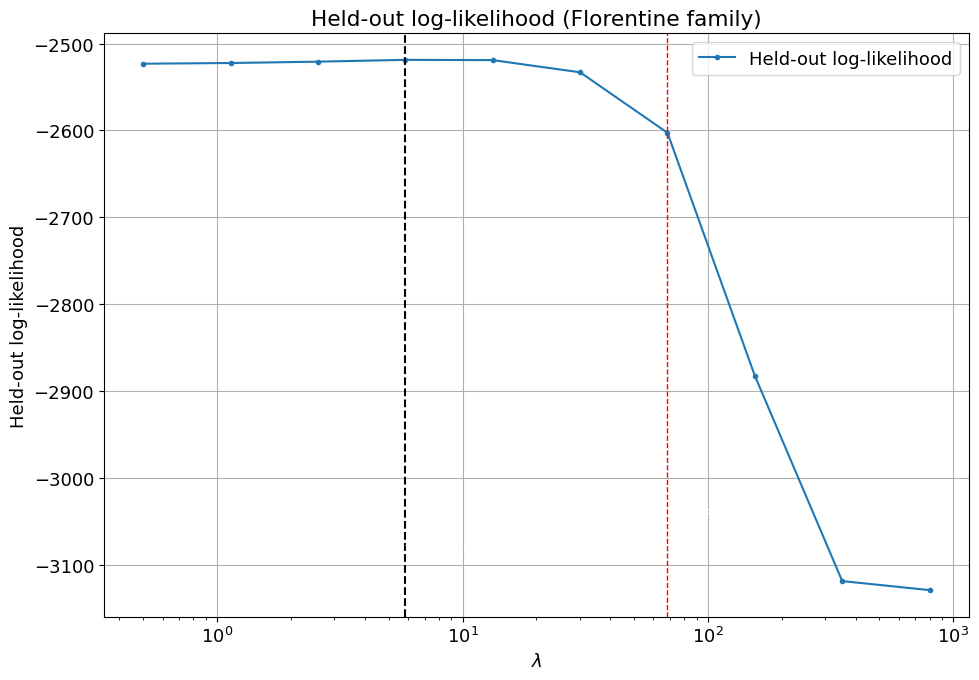

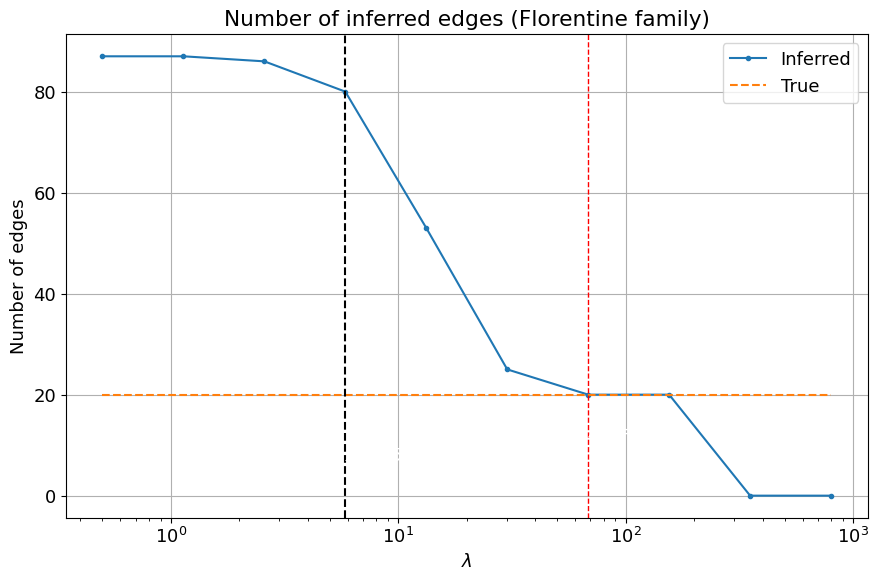

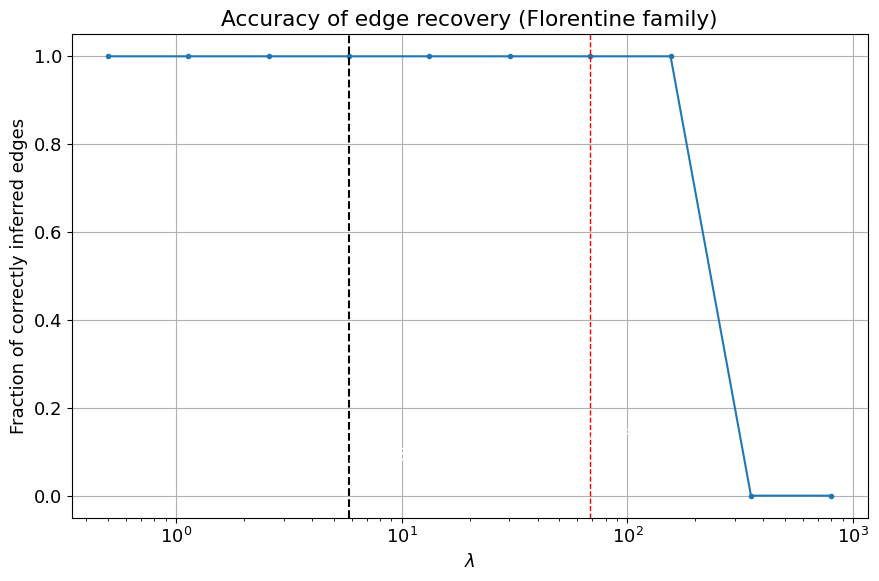

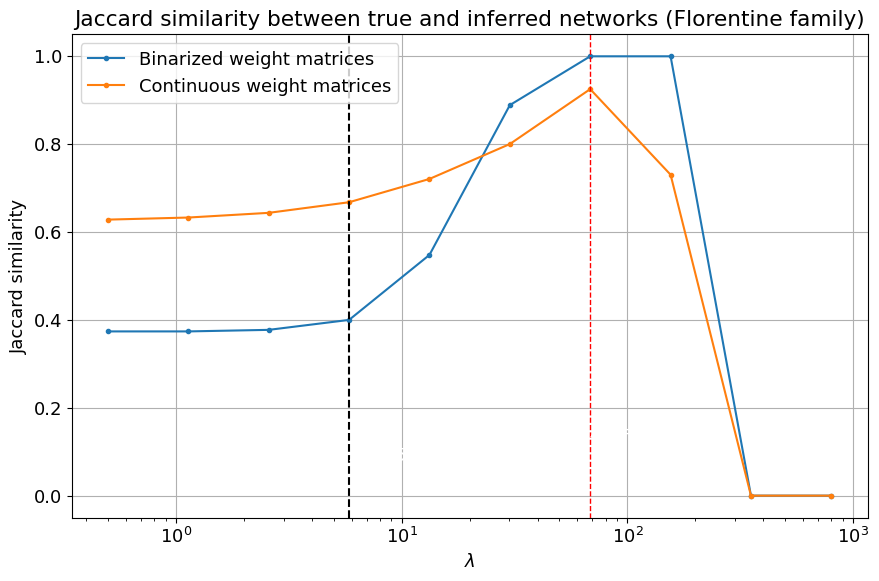

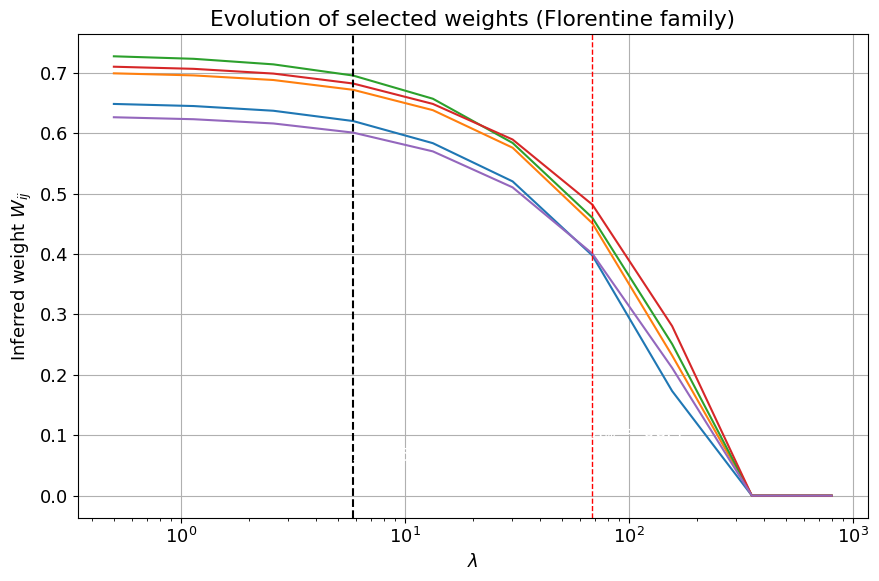

In [21]:

if NETWORK == "Karate":
    resp = "Karate Club"
    a = 0.85
    b = 0.6
    c = 0.85
    red = "right"
    green = "left"
    gold = "right"
elif NETWORK == "Miserable":
    resp = "Miserable"
elif NETWORK == "Family":
    resp = "Florentine family"
    a = 0.8
    b = 0.6
    c = 0.85
    red = "left"
    green = "right"
    gold = "left"

redcolor = "white"
greencolor = "white"
goldcolor = "white"
HoLL = True

plt.figure(figsize=(10, 7))
plt.rcParams.update({'font.size': 13})

plt.plot(lambda_grid, LogLik_array, ".-", label="Held-out log-likelihood")

ymin, ymax = plt.ylim()
dy = ymax - ymin

plt.axvline(x=best_lambdaW, color='red', linestyle='--', linewidth=1)
plt.text(best_lambdaW, ymax - a*dy,
         rf"$\lambda_W$ = {best_lambdaW:.1f}",
         color=redcolor, ha=red, va="top")
if NETWORK != "Family":
    plt.axvline(x=best_lambdaA, color='green', linestyle='--', linewidth=1)
    plt.text(best_lambdaA, ymax - b*dy,
             rf"$\lambda_A$ = {best_lambdaA:.1f}",
             color=greencolor, ha=green, va="top")
if HoLL:
    plt.axvline(x=best_lambdaLL, color='black', linestyle='--', linewidth=1.5)
    plt.text(best_lambdaLL, ymax - c*dy,
             rf"$\lambda_L$ = {best_lambdaLL:.1f}",
             color=goldcolor, ha=gold, va="top")

plt.legend()
plt.xscale('log')
plt.xlabel(r"$\lambda$")
plt.ylabel("Held-out log-likelihood")
plt.title(f"Held-out log-likelihood ({resp})")
plt.grid(True)
plt.tight_layout()
plt.savefig("HoutLL.png", dpi=300, bbox_inches='tight')
plt.show()



plt.figure(figsize=(9, 6))
plt.rcParams.update({'font.size': 13})
plt.plot(lambda_grid, Edge_values, ".-", label="Inferred")
plt.plot(lambda_grid, True_edges, "--", label="True")
ymin, ymax = plt.ylim()
dy = ymax - ymin

plt.axvline(x=best_lambdaW, color='red', linestyle='--', linewidth=1)
plt.text(best_lambdaW, ymax - a*dy,
         rf"$\lambda_W$ = {best_lambdaW:.1f}",
         color=redcolor, ha=red, va="top")

if NETWORK != "Family":
    plt.axvline(x=best_lambdaA, color='green', linestyle='--', linewidth=1)
    plt.text(best_lambdaA, ymax - b*dy,
             rf"$\lambda_A$ = {best_lambdaA:.1f}",
             color=greencolor, ha=green, va="top")

if HoLL:
    plt.axvline(x=best_lambdaLL, color='black', linestyle='--', linewidth=1.5)
    plt.text(best_lambdaLL, ymax - c*dy,
             rf"$\lambda_L$ = {best_lambdaLL:.1f}",
             color=goldcolor, ha=gold, va="top")

plt.legend()
plt.xscale('log')
plt.xlabel(r"$\lambda$")
plt.ylabel("Number of edges")
plt.title(f"Number of inferred edges ({resp})")
plt.grid(True)
plt.tight_layout()
plt.savefig("InferredEdges.png", dpi=300, bbox_inches='tight')


plt.figure(figsize=(9, 6))
plt.rcParams.update({'font.size': 13})
plt.plot(lambda_grid, CorrectInf_values / true_edges, ".-")
ymin, ymax = plt.ylim()
dy = ymax - ymin

plt.axvline(x=best_lambdaW, color='red', linestyle='--', linewidth=1)
plt.text(best_lambdaW, ymax - a*dy,
         rf"$\lambda_W$ = {best_lambdaW:.1f}",
         color=redcolor, ha=red, va="top")

if NETWORK != "Family":
    plt.axvline(x=best_lambdaA, color='green', linestyle='--', linewidth=1)
    plt.text(best_lambdaA, ymax - b*dy,
             rf"$\lambda_A$ = {best_lambdaA:.1f}",
             color=greencolor, ha=green, va="top")

if HoLL:
    plt.axvline(x=best_lambdaLL, color='black', linestyle='--', linewidth=1.5)
    plt.text(best_lambdaLL, ymax - c*dy,
             rf"$\lambda_L$ = {best_lambdaLL:.1f}",
             color=goldcolor, ha=gold, va="top")

plt.xscale('log')
plt.xlabel(r"$\lambda$")
plt.ylabel("Fraction of correctly inferred edges")
plt.title(f"Accuracy of edge recovery ({resp})")
plt.grid(True)
plt.tight_layout()
plt.savefig("CorrectInfEdgesRatio.png", dpi=300, bbox_inches='tight')


plt.figure(figsize=(9, 6))
plt.rcParams.update({'font.size': 13})
plt.plot(lambda_grid, JaccSimA_values, ".-", label="Binarized weight matrices")
plt.plot(lambda_grid, JaccSimW_values, ".-", label="Continuous weight matrices")
ymin, ymax = plt.ylim()
dy = ymax - ymin

plt.axvline(x=best_lambdaW, color='red', linestyle='--', linewidth=1)
plt.text(best_lambdaW, ymax - a*dy,
         rf"$\lambda_W$ = {best_lambdaW:.1f}",
         color=redcolor, ha=red, va="top")

if NETWORK != "Family":
    plt.axvline(x=best_lambdaA, color='green', linestyle='--', linewidth=1)
    plt.text(best_lambdaA, ymax - b*dy,
             rf"$\lambda_A$ = {best_lambdaA:.1f}",
             color=greencolor, ha=green, va="top")

if HoLL:
    plt.axvline(x=best_lambdaLL, color='black', linestyle='--', linewidth=1.5)
    plt.text(best_lambdaLL, ymax - c*dy,
             rf"$\lambda_L$ = {best_lambdaLL:.1f}",
             color=goldcolor, ha=gold, va="top")

plt.legend()
plt.xscale('log')
plt.xlabel(r"$\lambda$")
plt.ylabel("Jaccard similarity")
plt.title(f"Jaccard similarity between true and inferred networks ({resp})")
plt.grid(True)
plt.tight_layout()
plt.savefig("JaccardSimilarity.png", dpi=300, bbox_inches='tight')


plt.figure(figsize=(9, 6))
plt.rcParams.update({'font.size': 13})
for k, (ii, jj) in enumerate(test_pairs):
    plt.plot(lambda_grid, Winf_values[:, k], "-", label=rf"$W_{{{ii},{jj}}}$")
ymin, ymax = plt.ylim()
dy = ymax - ymin

plt.axvline(x=best_lambdaW, color='red', linestyle='--', linewidth=1)
plt.text(best_lambdaW, ymax - a*dy,
         rf"$\lambda_W$ = {best_lambdaW:.1f}",
         color=redcolor, ha=red, va="top")

if NETWORK != "Family":
    plt.axvline(x=best_lambdaA, color='green', linestyle='--', linewidth=1)
    plt.text(best_lambdaA, ymax - b*dy,
             rf"$\lambda_A$ = {best_lambdaA:.1f}",
             color=greencolor, ha=green, va="top")

if HoLL:
    plt.axvline(x=best_lambdaLL, color='black', linestyle='--', linewidth=1.5)
    plt.text(best_lambdaLL, ymax - c*dy,
             rf"$\lambda_L$ = {best_lambdaLL:.1f}",
             color=goldcolor, ha=gold, va="top")

plt.xscale('log')
plt.xlabel(r"$\lambda$")
plt.ylabel(r"Inferred weight $W_{ij}$")
plt.title(f"Evolution of selected weights ({resp})")
plt.grid(True)
#plt.legend()
plt.tight_layout()
plt.savefig("Weights.png", dpi=300, bbox_inches='tight')


plt.show()



In [222]:
def plot_weighted_network(W, threshold=0.0, title=None, seed=0):
    """
    W: matrice NxN dei pesi (numpy array)
    threshold: tieni solo archi con |W_ij| > threshold
    """

    W = np.asarray(W)
    # --- (1) maschera / soglia ---
    W_thr = W.copy()

    W_thr[np.abs(W_thr) <= threshold] = 0.0
    np.fill_diagonal(W_thr, 0.0)

    # creo grafo
    G = nx.from_numpy_array(W_thr)

    # tolgo i nodi isolati
    G.remove_nodes_from(list(nx.isolates(G)))

    # layout
    pos = nx.spring_layout(G, seed=seed, k=None)
    N = G.number_of_nodes()
    E = G.number_of_edges()
    
    # prepara attributi archi
    edges = list(G.edges())
    weights = np.array([W_thr[i, j] for i, j in edges])

    # colore archi: rosso se vicini alla media vera, blu altrimenti
    edge_colors = ["red" if np.abs(w - N/(2*E)) < 0.01 else "blue" for w in weights]

    # spessore archi proporzionale al modulo
    abs_w = np.abs(weights)
    if len(abs_w) > 0:
        edge_widths = 0.5 + 4 * (abs_w / abs_w.max())
    else:
        edge_widths = 1.0

    # --- (5) disegno ---
    plt.figure(figsize=(7, 6))
    nx.draw_networkx_nodes(G, pos, node_size=200, node_color="grey", alpha=0.8)
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths, alpha=0.8)
    #nx.draw_networkx_labels(G, pos, font_size=9, font_color="white")

    if title is not None:
        plt.title(title)

    plt.axis("off")
    plt.tight_layout()
    plt.show()

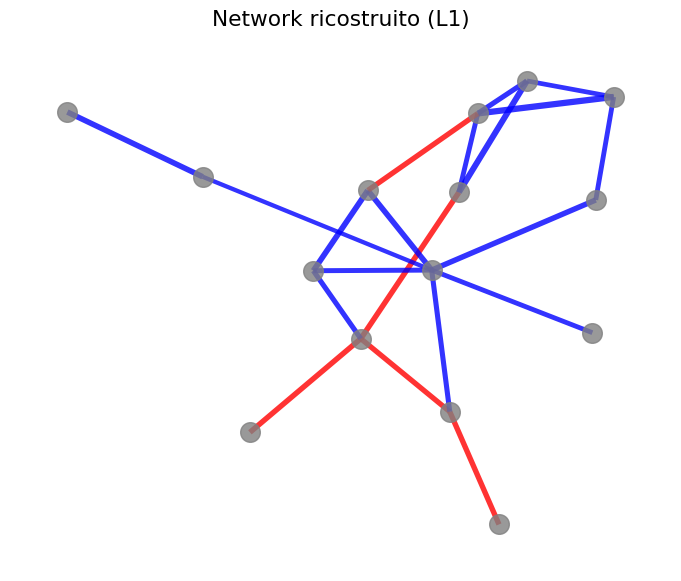

In [224]:
plot_weighted_network(best_WmatrixW, threshold=0.0, title="Network ricostruito (L1)")

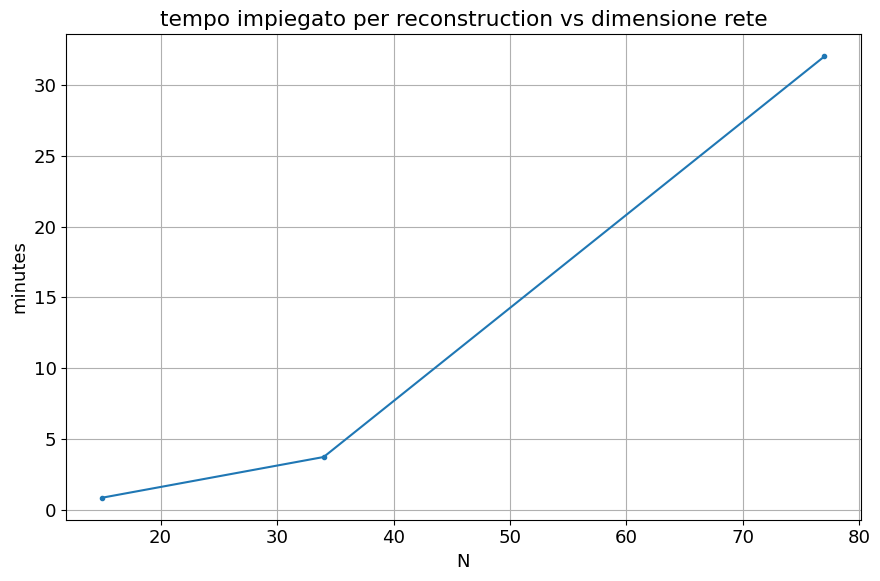

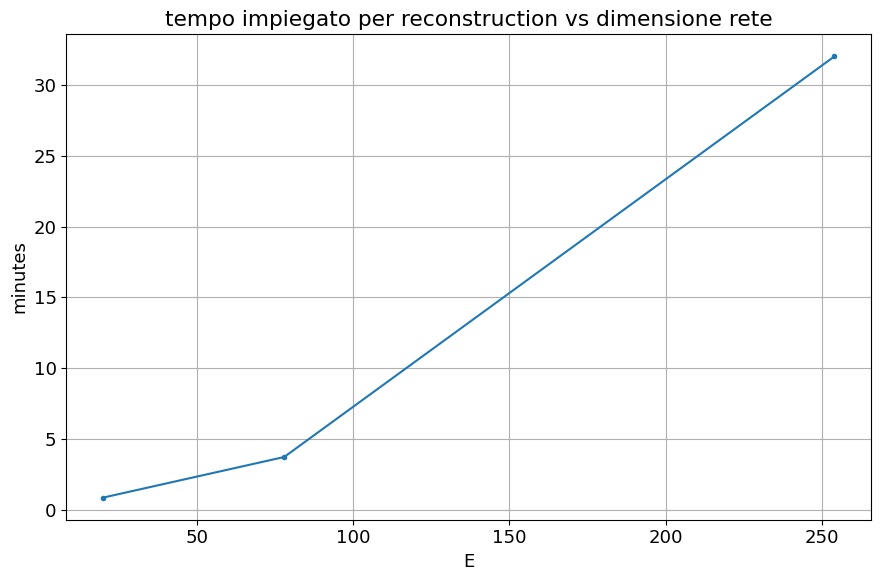

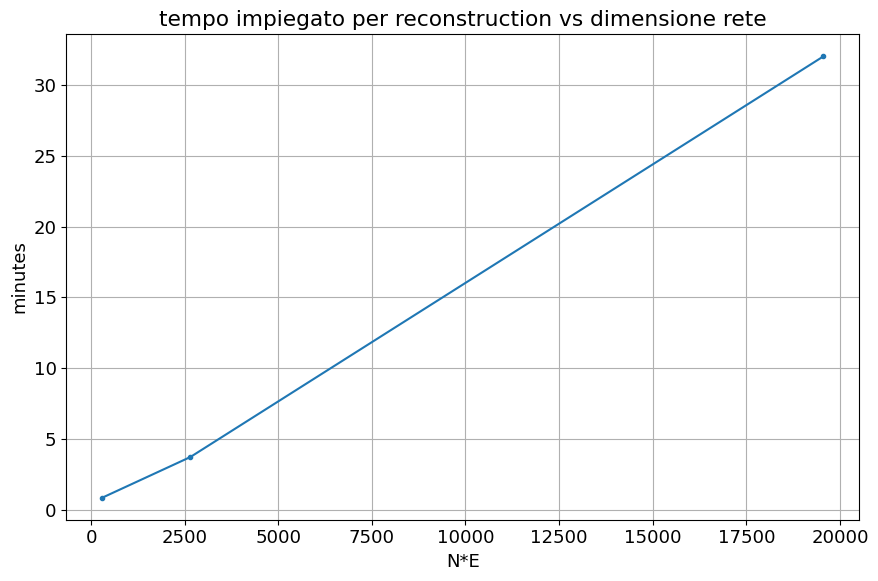

In [462]:
N = [15, 34, 77]
E = [20, 78, 254]
x = [n*e for n, e in zip(N,E)]
y = np.array([0, 3, 32]) + np.array([53, 45, 0])/60
plt.figure(figsize=(9, 6))
plt.rcParams.update({'font.size': 13})
plt.plot(N, y, ".-", label="Binarized weight matrices")
plt.xlabel(r"N")
plt.ylabel("minutes")
plt.title(f"tempo impiegato per reconstruction vs dimensione rete")
plt.grid(True)
plt.tight_layout()
plt.savefig("JaccardSimilarity.png", dpi=300, bbox_inches='tight')

plt.figure(figsize=(9, 6))
plt.rcParams.update({'font.size': 13})
plt.plot(E, y, ".-", label="Binarized weight matrices")
plt.xlabel(r"E")
plt.ylabel("minutes")
plt.title(f"tempo impiegato per reconstruction vs dimensione rete")
plt.grid(True)
plt.tight_layout()
plt.savefig("JaccardSimilarity.png", dpi=300, bbox_inches='tight')

plt.figure(figsize=(9, 6))
plt.rcParams.update({'font.size': 13})
plt.plot(x, y, ".-", label="Binarized weight matrices")
plt.xlabel(r"N*E")
plt.ylabel("minutes")
plt.title(f"tempo impiegato per reconstruction vs dimensione rete")
plt.grid(True)
plt.tight_layout()
plt.savefig("JaccardSimilarity.png", dpi=300, bbox_inches='tight')

plt.show()